In [2]:
from gensim.models import Word2Vec
import gensim
import re
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from nltk.corpus import stopwords # Import the stop word list
print(stopwords.words("english") )

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [145]:
def preprocessing_sentence(sentence, delete_stopwords = True):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", sentence) 
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    if delete_stopwords:
        # 3. In Python, searching a set is much faster than searching
        #   a list, so convert the stop words to a set
        stops = set(stopwords.words("english"))                  
        # 
        # 4. Remove stop words
        meaningful_words = [w for w in words if not w in stops]   
        #
        # 5. Join the words back into one string separated by space, 
        # and return the result.
    else:
        meaningful_words = words
    
    return( " ".join( meaningful_words ))   

def sentence_to_vec(sent, model):
    words = sent.split(" ")
    temp = []
    for w in words:
        if w in model:
            temp.append(model[w])
    if temp:
        temp = list((np.array(temp)).mean(0)) + list(np.percentile(np.array(temp), 25, axis=0))
    else:
        temp = list(np.zeros(300))
    return np.array(temp)

def cosine(vector1, vector2):
    ab = 0
    a = 0
    b = 0
    for i in range(vector1.shape[0]):
        ab += vector1[i]*vector2[i]
        a += math.pow(vector1[i],2)
        b += math.pow(vector2[i],2)
    return ab/(math.sqrt(a)*math.sqrt(b))

In [5]:
print("loading model")
Vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print("loaded model!")
model_google = None
try:
    model_google = Vec.wv
except Exception:
    model_google = Vec

loading model
loaded model!


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [6]:
Vec.wv

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [57]:
train = pd.read_csv("faq_new.csv", encoding = "ISO-8859-1")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 3 columns):
Q    290 non-null object
S    215 non-null object
A    290 non-null object
dtypes: object(3)
memory usage: 6.9+ KB


In [72]:
train.head()

,Q,S,A
0,What is a quote?,Is a quote a cost estimate?,"An insurance quote is a cost estimate, an earl..."
1,Why do you need my email address just to provi...,Why do you need my email for a quote?,"Your email address, name and phone number iden..."
2,Why do I have to provide my date of birth to g...,Why do you want my birthdate to give me a quote?,"With your birthdate, and a few other pieces of..."
3,Why do you order consumer reports for quotes?,Why do you look at my credit to make a quote?,Your credit history is important information t...
4,Who should I include on my Auto insurance quote?,Who should I put in my quote?,Your quote should include the following people...


In [97]:
#for our first idea to check whether algoruthm works properly I am going to compare synonyms with their question, 
#therefore there is no sense in rows with empty values
train.dropna(inplace=True)
train.info()
train = train.reset_index().drop('index', axis= 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 3 columns):
Q    215 non-null object
S    215 non-null object
A    215 non-null object
dtypes: object(3)
memory usage: 6.7+ KB


In [98]:
questions = train.Q
#synonyms_with_nan = train.S
#synonyms_with_nan.dropna(inplace=True)
#synonyms = synonyms_with_nan.reset_index().S

In [89]:
# Initialize an empty list to hold the clean sentenscs
clean_questions = []

for i in range(len(questions)):
    clean_questions.append( preprocessing_sentence(questions[i]))
    
vectors_questions = []

for i in range(len(clean_questions)):
    vectors_questions.append( sentence_to_vec(clean_questions[i], model_google))

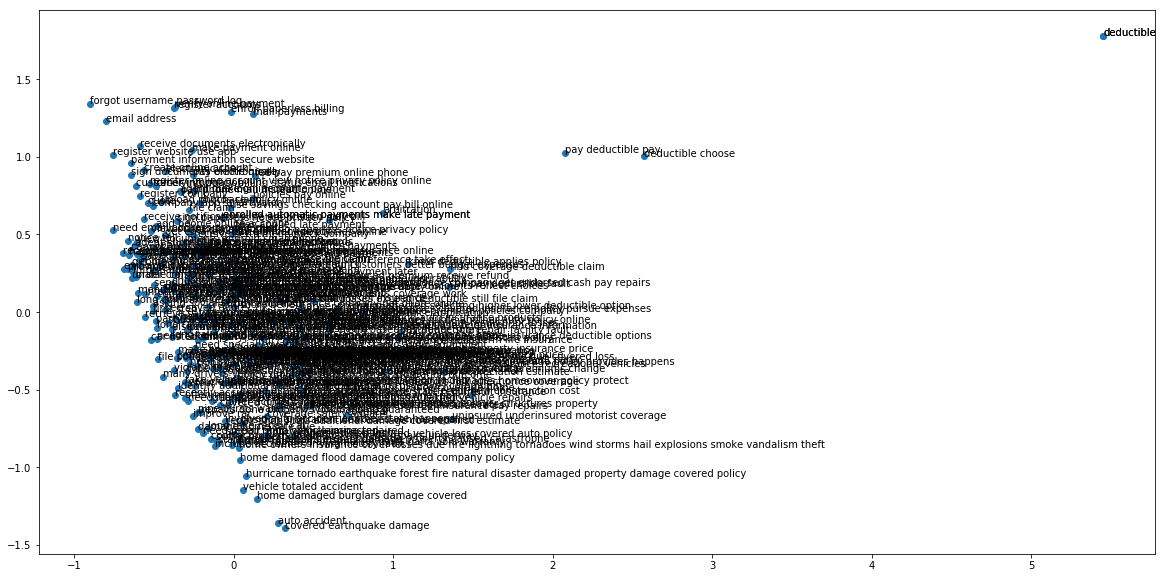

In [13]:
X = vectors_questions

pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20,10))
plt.scatter(result[:, 0], result[:, 1])
words = list(clean_questions)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [213]:
user_questions = train.S
clean_user_questions = []

for i in range(len(user_questions)):
    clean_user_questions.append( preprocessing_sentence(user_questions[i]))
    
vectors_users = []

for i in range(len(clean_questions)):
    vectors_users.append( sentence_to_vec(clean_user_questions[i], model_google))

Here is an example of one task I can imagine

Let's think we don't know the the pair "question-synonym"

In real word we can have a database only with pairs "question-answer"

But the question form can vary much depending on user 

And if we have strange question from user, we can find the most similar question and then write the answer associated with most suitable found question

In [82]:
user_question = user_questions[0]

user_vector = sentence_to_vec(user_question, model_google)
    
better_syn_questions = ''
max_cos_questions = -1
    
for i in range(len(clean_questions)):
    vectors_question = sentence_to_vec(clean_questions[i], model_google)
    cos = cosine(user_vector, vectors_question)
    if cos > max_cos_questions:
        max_cos_questions = cos
        better_syn_questions = clean_questions[i]
print(better_syn_questions)
print(max_cos_questions)

get life quote phone receive copy quote
0.6327612151893971


In [70]:
train.A[0]

'An insurance quote is a cost estimate, an early calculation of what you will pay. It is based on information about you and the coverage options you chose. Receiving a quote does not mean you have insurance and or that you are being offered coverage. There are some additional calculations and checking that we do before you can finish getting insurance coverage.'

In [83]:
index = clean_questions.index(better_syn_questions)
answer_dict = {}
answer = train.A[index]
answer_dict["most_similar_question"] = train.Q[index]
answer_dict["answer"] = train.A[index]
answer_dict["score"] = max_cos_questions
print(user_question)
print(answer_dict)

Is a quote a cost estimate?
{'most_similar_question': 'If I get a life quote over the phone, can I receive a copy of my quote?', 'answer': 'You can ask us to send you a copy of recent quotes. We can find the quote using your name, email and/or phone number.', 'score': 0.6327612151893971}


Unfortunately, the answer doesn't fit the user's question

Ok, now we can look throught all found pairs "question-synonym" and estimate the performance of the system based on the mean of all cosine distances (because actually the cosine distance is the similarity measure in our case and we can represent is as "accuracy").

In [105]:
scores = []
for j in range(len(clean_user_questions)):
    user_question = clean_user_questions[j]

    user_vector = sentence_to_vec(user_question, model_google)
    
    better_syn_questions = ''
    max_cos_questions = -1
    
    for i in range(len(clean_questions)):
        question_vector = sentence_to_vec(clean_questions[i], model_google)
        cos = cosine(user_vector, question_vector)
        if cos > max_cos_questions:
            max_cos_questions = cos
            better_syn_questions = questions[i]
    scores.append(max_cos_questions)
    print("**************************")
    print("User question:")
    print(user_questions[j])
    print("Best suitable synonym question:")
    print(better_syn_questions)
    print("Cosine score between 2 sentences")
    print(max_cos_questions)
print(np.array(scores).mean())

**************************
User question:
Is a quote a cost estimate?
Best suitable synonym question:
I have replacement cost coverage. Why did you show depreciation on the estimate?
Cosine score between 2 sentences
0.7386908319001141
**************************
User question:
Why do you need my email for a quote?
Best suitable synonym question:
Why do you need my email address just to provide me with a quote?
Cosine score between 2 sentences
0.8528793926597038
**************************
User question:
Why do you want my birthdate to give me a quote?
Best suitable synonym question:
Why do I have to provide my date of birth to get a quote?
Cosine score between 2 sentences
0.732778609449961
**************************
User question:
Why do you look at my credit to make a quote?
Best suitable synonym question:
If I get a life quote over the phone, can I receive a copy of my quote?
Cosine score between 2 sentences
0.718100126656198
**************************
User question:
Who should I put i

**************************
User question:
I can't find my policy information. How do I find it?
Best suitable synonym question:
How do I find my policy or account number?
Cosine score between 2 sentences
0.7123391145308091
**************************
User question:
Do I have to do the privacy notice every year?
Best suitable synonym question:
Why should I sign up for the Paperless Notice of Privacy Policy?
Cosine score between 2 sentences
0.7606828337448651
**************************
User question:
What if my appication is rejected?
Best suitable synonym question:
What happens if my application is rejected during the application process?
Cosine score between 2 sentences
0.34782606050562553
**************************
User question:
What information will I need to fill out for life insurance?
Best suitable synonym question:
What type of information do I need to complete a life insurance application?
Cosine score between 2 sentences
0.8447982536934231
**************************
User questi

**************************
User question:
What are the car insurance discounts you have?
Best suitable synonym question:
What kinds of Auto insurance discounts are available?
Cosine score between 2 sentences
0.8031515558634588
**************************
User question:
Are there homeowners insurance discounts available?
Best suitable synonym question:
What kinds of Auto insurance discounts are available?
Cosine score between 2 sentences
0.8300302541529866
**************************
User question:
Can I get a life insurance discount if I have other policies with your company?
Best suitable synonym question:
Can I get a discount on my life insurance premium if I have other policies with [company]?
Cosine score between 2 sentences
0.9644797472364435
**************************
User question:
Do good students get a discount?
Best suitable synonym question:
What is a Good Student Discount?
Cosine score between 2 sentences
0.8627810555209203
**************************
User question:
Where can 

**************************
User question:
My credit information is wrong. How do I correct it?
Best suitable synonym question:
What if the information in my credit report is wrong?
Cosine score between 2 sentences
0.8819154092052839
**************************
User question:
Since my premium is based on how risky it is to insure me, tell me about how you calculate this risk.
Best suitable synonym question:
How do insurance companies assess risk?
Cosine score between 2 sentences
0.7371980582584307
**************************
User question:
Can I get notices about your Privacy Policy emailed to me instead of paper mailed?
Best suitable synonym question:
Can I get an emailed Notice of Privacy Policy?
Cosine score between 2 sentences
0.836739455739197
**************************
User question:
Do I really need an online account to view the privacy policy notice?
Best suitable synonym question:
Why do I have to register for an online account before I can view my Notice of Privacy Policy online

**************************
User question:
What is bodily injury coverage?
Best suitable synonym question:
How does bodily injury coverage work?
Cosine score between 2 sentences
0.9314643758055065
**************************
User question:
Who pays for my lost income if I'm injured and can't work?
Best suitable synonym question:
If I can't work because of my injuries, who pays my lost wages?
Cosine score between 2 sentences
0.8485321464740769
**************************
User question:
Are all kinds of life insurance offered online?
Best suitable synonym question:
Are all life insurance products available to apply online?
Cosine score between 2 sentences
0.8163058489959455
**************************
User question:
If someone is hurt on my property, am I covered?
Best suitable synonym question:
If property is stolen from my insured vehicle, is the loss covered by my auto policy?
Cosine score between 2 sentences
0.7279157904756495
**************************
User question:
What if the value o

**************************
User question:
Why are reconstruction costs different from new construction costs?
Best suitable synonym question:
Why is my homeÕs estimated reconstruction cost different than the new construction cost?
Cosine score between 2 sentences
0.8765727442945461
**************************
User question:
Are there safety systems I can install to earn a discount on my policy?
Best suitable synonym question:
Will I get a discount for signing up for the Paperless Notice of Privacy Policy?
Cosine score between 2 sentences
0.7125710037070426
**************************
User question:
What if my home or property changes? Will I have to change my coverage?
Best suitable synonym question:
If repairs take longer than the loss of use or rental reimbursement coverage in my policy provides for, what happens?
Cosine score between 2 sentences
0.6677598749319171
**************************
User question:
Am I covered if I have extra rebuilding costs to meet current building codes?
Be

**************************
User question:
How do I get proof of insurance?
Best suitable synonym question:
How do I view my proof of insurance?
Cosine score between 2 sentences
0.8643714974708356
**************************
User question:
Are my customizations covered?
Best suitable synonym question:
Is my optional equipment covered?
Cosine score between 2 sentences
0.6133534271525386
**************************
User question:
Is my safety equipment covered?
Best suitable synonym question:
Is my optional equipment covered?
Cosine score between 2 sentences
0.7736243533258191
**************************
User question:
Is there accident forgiveness?
Best suitable synonym question:
Do you offer Accident Forgiveness?
Cosine score between 2 sentences
0.8887726241342465
**************************
User question:
Do you have roadside assistance for motorcycles?
Best suitable synonym question:
Does [company] offer Roadside Assistance?
Cosine score between 2 sentences
0.7598627839606205
0.7792415025

In [106]:
##The accuracy of full model
print(np.array(scores).mean())

0.779241502503188


Changed text preprocessing (without removing stopwords)

In [107]:
clean_questions = []

for i in range(len(questions)):
    clean_questions.append( preprocessing_sentence(questions[i], delete_stopwords = False))
    
clean_user_questions = []

for i in range(len(questions)):
    clean_user_questions.append( preprocessing_sentence(user_questions[i], delete_stopwords = False))

    
scores = []
for j in range(len(clean_user_questions)):
    user_question = clean_user_questions[j]

    user_vector = sentence_to_vec(user_question, model_google)
    
    better_syn_questions = ''
    max_cos_questions = -1
    
    for i in range(len(clean_questions)):
        question_vector = sentence_to_vec(clean_questions[i], model_google)
        cos = cosine(user_vector, question_vector)
        if cos > max_cos_questions:
            max_cos_questions = cos
            better_syn_questions = questions[i]
    scores.append(max_cos_questions)
    print("**************************")
    print("User question:")
    print(user_questions[j])
    print("Best suitable synonym question:")
    print(better_syn_questions)
    print("Cosine score between 2 sentences")
    print(max_cos_questions)
print(np.array(scores).mean())

**************************
User question:
Is a quote a cost estimate?
Best suitable synonym question:
What is a quote?
Cosine score between 2 sentences
0.6993942751892822
**************************
User question:
Why do you need my email for a quote?
Best suitable synonym question:
Why do you need my email address just to provide me with a quote?
Cosine score between 2 sentences
0.9555740323024627
**************************
User question:
Why do you want my birthdate to give me a quote?
Best suitable synonym question:
Why do you need my email address just to provide me with a quote?
Cosine score between 2 sentences
0.9023474653105513
**************************
User question:
Why do you look at my credit to make a quote?
Best suitable synonym question:
Why do you need my email address just to provide me with a quote?
Cosine score between 2 sentences
0.8867894534619805
**************************
User question:
Who should I put in my quote?
Best suitable synonym question:
If I get a life 

**************************
User question:
Do I have to do the privacy notice every year?
Best suitable synonym question:
Why do I have to register for an online account before I can view my Notice of Privacy Policy online?
Cosine score between 2 sentences
0.8414188555236289
**************************
User question:
What if my appication is rejected?
Best suitable synonym question:
What happens if my application is rejected during the application process?
Cosine score between 2 sentences
0.8040459653819486
**************************
User question:
What information will I need to fill out for life insurance?
Best suitable synonym question:
What type of information do I need to complete a life insurance application?
Cosine score between 2 sentences
0.8993919740014661
**************************
User question:
What if I can't finish the application online?
Best suitable synonym question:
What if I don't have all the information about my loss right now? Should I wait to file a claim?
Cosine 

**************************
User question:
My car has special safety equipment. How do I get a discount?
Best suitable synonym question:
Do I need special coverage if I add features to my car?
Cosine score between 2 sentences
0.8817310217443248
**************************
User question:
What are the car insurance discounts you have?
Best suitable synonym question:
What kinds of Auto insurance discounts are available?
Cosine score between 2 sentences
0.8684116964597502
**************************
User question:
Are there homeowners insurance discounts available?
Best suitable synonym question:
What kinds of Auto insurance discounts are available?
Cosine score between 2 sentences
0.8551438131655046
**************************
User question:
Can I get a life insurance discount if I have other policies with your company?
Best suitable synonym question:
Can I get a discount on my life insurance premium if I have other policies with [company]?
Cosine score between 2 sentences
0.9739848840780071


**************************
User question:
How will I know if I am missing discounts because of my credit information?
Best suitable synonym question:
What if I don't have all the information about my loss right now? Should I wait to file a claim?
Cosine score between 2 sentences
0.8668606804421389
**************************
User question:
My credit information is wrong. How do I correct it?
Best suitable synonym question:
What if the information in my credit report is wrong?
Cosine score between 2 sentences
0.8888197604597888
**************************
User question:
Since my premium is based on how risky it is to insure me, tell me about how you calculate this risk.
Best suitable synonym question:
Why is my settlement check made payable to both me and my mortgage company? How do I get it endorsed so I can cash it to pay for repairs?
Cosine score between 2 sentences
0.8742207612503908
**************************
User question:
Can I get notices about your Privacy Policy emailed to me in

**************************
User question:
How do I start a claim?
Best suitable synonym question:
How do I notify [company] of a claim?
Cosine score between 2 sentences
0.8415007172394601
**************************
User question:
What is personal injury coverage?
Best suitable synonym question:
What is personal injury protection?
Cosine score between 2 sentences
0.8657370409739261
**************************
User question:
What is medical payment coverage?
Best suitable synonym question:
How does medical payments coverage work?
Cosine score between 2 sentences
0.8563903297073684
**************************
User question:
What is bodily injury coverage?
Best suitable synonym question:
How does bodily injury coverage work?
Cosine score between 2 sentences
0.8990452699921359
**************************
User question:
Who pays for my lost income if I'm injured and can't work?
Best suitable synonym question:
If I can't work because of my injuries, who pays my lost wages?
Cosine score between 2

**************************
User question:
Someone told me I should hire a public adjuster. What is that?
Best suitable synonym question:
Why is my settlement check made payable to both me and my mortgage company? How do I get it endorsed so I can cash it to pay for repairs?
Cosine score between 2 sentences
0.8508942405418816
**************************
User question:
What are the homeowner's insurance discounts I can get?
Best suitable synonym question:
Can I get a discount on my life insurance premium if I have other policies with [company]?
Cosine score between 2 sentences
0.8746630884542943
**************************
User question:
Why does it matter if I had a loss before?
Best suitable synonym question:
What else can I do if I have time before my first meeting with a [company] claims representative?
Cosine score between 2 sentences
0.8620241311642463
**************************
User question:
Will you tell me if my old loss affected my current policy?
Best suitable synonym question:

**************************
User question:
How common is arbitration?
Best suitable synonym question:
Is it common for arbitration to occur?
Cosine score between 2 sentences
0.8521782250893549
**************************
User question:
Does it matter in arbitration if I fixed my car or not?
Best suitable synonym question:
Is our position in arbitration weakened because I did not have my vehicle repaired?
Cosine score between 2 sentences
0.8756906624799111
**************************
User question:
How do I get reimbursed for out of pocket expenses related to arbitration?
Best suitable synonym question:
I paid some expenses myself that were not covered by my insurance policy. How can I pursue these expenses?
Cosine score between 2 sentences
0.8576850535283949
**************************
User question:
Will the arbitration decision affect my policy or be on my driving record?
Best suitable synonym question:
Will my policy or driving record be impacted by the arbitration outcome?
Cosine score

In [108]:
##The accuracy of full model
print(np.array(scores).mean())

0.8757105345267995


 Next idea was to discover how to train my own model with different parameter settings

In [196]:
clean_questions = []

for i in range(len(questions)):
    clean_questions.append(preprocessing_sentence(questions[i]))
    #clean_questions.append(preprocessing_sentence(questions[i], delete_stopwords = False))
    
clean_user_questions = []

for i in range(len(user_questions)):
    clean_user_questions.append( preprocessing_sentence(user_questions[i]))
    #clean_user_questions.append( preprocessing_sentence(user_questions[i], delete_stopwords = False))

In [197]:
##!!Gensim accepts input in form of list of lists, where each internal list consists of review sentence.
sentences = []
for i in range(len(clean_questions)):
    sent_spl = clean_questions[i].split(" ")
    sentences.append(sent_spl)

**size**
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. 

**window** 
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

**min_count**
Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

**workers**
How many threads to use behind the scenes?

https://github.com/kavgan/nlp-text-mining-working-examples/blob/master/word2vec/Word2Vec.ipynb

In [198]:
# train model
# sg - skip gram |  window = size of the window | size = vector dimension
size = 5
window_size = 1 
epochs = 100
min_count = 2
workers = 4

model1 = Word2Vec(sentences, sg=1,window=window_size,size=size,
                 min_count=min_count,workers=workers,iter=epochs,sample=0.01)
# summarize the loaded model
print(model1)
# summarize vocabulary
words = list(model1.wv.vocab)
#print(words)
print("The number of words in vocabulary is %d" %len(words))
# save model
model1.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=168, size=5, alpha=0.025)
The number of words in vocabulary is 168
Word2Vec(vocab=168, size=5, alpha=0.025)


In [199]:
scores = []
for j in range(len(clean_user_questions)):
    user_question = clean_user_questions[j]

    user_vector = sentence_to_vec(user_question, new_model)
    
    better_syn_questions = ''
    max_cos_questions = -1
    
    for i in range(len(clean_questions)):
        question_vector = sentence_to_vec(clean_questions[i], new_model)
        cos = cosine(user_vector, question_vector)
        if cos > max_cos_questions:
            max_cos_questions = cos
            better_syn_questions = questions[i]
    scores.append(max_cos_questions)
    print("**************************")
    print("User question:")
    print(user_questions[j])
    print("Best suitable synonym question:")
    print(better_syn_questions)
    print("Cosine score between 2 sentences")
    print(max_cos_questions)
print(np.array(scores).mean())

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


**************************
User question:
Is a quote a cost estimate?
Best suitable synonym question:
Do I need special coverage if I add features to my car?
Cosine score between 2 sentences
0.9401472567666083
**************************
User question:
Why do you need my email for a quote?
Best suitable synonym question:
My spouse or civil partner has their own insurance. Do I need to include them on this quote?
Cosine score between 2 sentences
0.9750271523054955
**************************
User question:
Why do you want my birthdate to give me a quote?
Best suitable synonym question:
What is a quote?
Cosine score between 2 sentences
1.0
**************************
User question:
Why do you look at my credit to make a quote?
Best suitable synonym question:
Why do you need my email address just to provide me with a quote?
Cosine score between 2 sentences
0.9735181781541031
**************************
User question:
Who should I put in my quote?
Best suitable synonym question:
What is a quot

IndexError: index 10 is out of bounds for axis 0 with size 10

In [194]:
##The accuracy of full model
print(np.array(scores).mean())

0.9753197305858626


Also by the way I can just play and check the similar words to the given one. It can be done in one row: to call the most_similar function and provide the word as the positive example. This returns the top 10 similar words.

In [207]:
w1 = ["insurance"]
new_model.wv.most_similar (positive=w1,topn=10)

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('term', 0.9649817943572998),
 ('save', 0.9601805806159973),
 ('complete', 0.9551661610603333),
 ('email', 0.9522020816802979),
 ('much', 0.9450080990791321),
 ('kinds', 0.9201043844223022),
 ('best', 0.9060388207435608),
 ('apply', 0.9025301933288574),
 ('discount', 0.9012689590454102),
 ('accident', 0.8934975862503052)]

In [201]:
w1 = ["rental"]
new_model.wv.most_similar (positive=w1,topn=5)

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('liability', 0.9979413151741028),
 ('protection', 0.9857190847396851),
 ('work', 0.9827917814254761),
 ('consider', 0.9804590940475464),
 ('safety', 0.9700043201446533)]

In [209]:
X = model1[new_model.wv.vocab]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


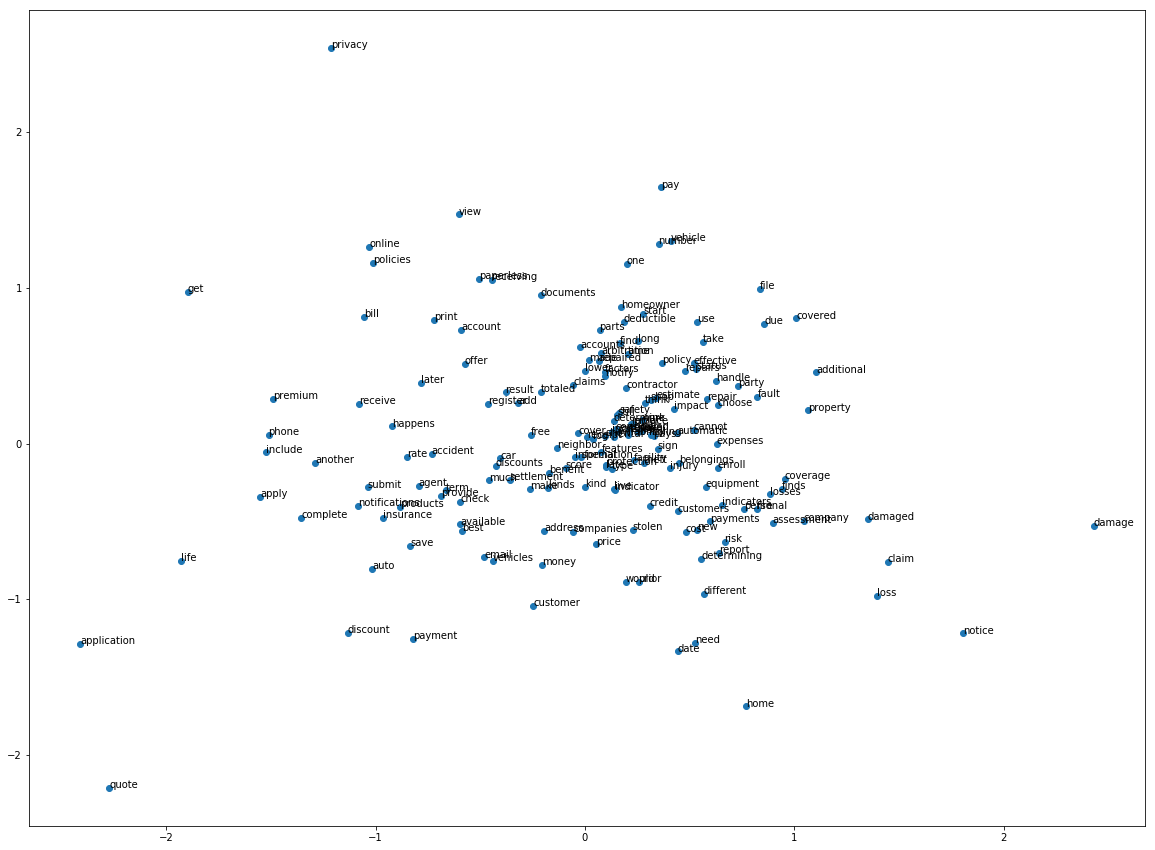

In [211]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.scatter(result[:, 0], result[:, 1])
words = list(model1.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Describe the process of tokenisation and why it is important to do it

A pre-trained model is nothing more than a file containing tokens and their associated word vectors. The pre-trained Google word2vec model was trained on Google news data (about 100 billion words); it contains 3 million words and phrases and was fit using 300-dimensional word vectors.

Maybe we don't need to remove stoplist words, because we have small sentences, not review

In [34]:
user_question = preprocessing_sentence(user_question)

answer_dict = {}

user_vector = sentence_to_vec(user_question, model)
    
better_syn_questions = ''
max_cos_questions = -1
    
for i in range(len(clean_questions)):
    vectors_question = sentence_to_vec(clean_questions[i], model)
    cos = cosine(user_vector, vectors_question)
    if cos > max_cos_questions:
        max_cos_questions = cos
        better_syn_questions = clean_questions[i]
print(better_syn_questions)
print(max_cos_questions)

better_syn_synonyms = ''
max_cos_synonyms = -1
    
for i in range(len(clean_synonyms)):
    vectors_synonyms = sentence_to_vec(clean_synonyms[i], model)
    cos = cosine(user_vector, vectors_synonyms)
    if cos > max_cos_synonyms:
        max_cos_synonyms = cos
        better_syn_synonyms = clean_synonyms[i]
print(better_syn_synonyms)
print(max_cos_synonyms)

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


get discount signing paperless notice privacy policy
0.8938269581651849
get electronic copies documents
0.9999999999999999
